# 2022 Alaska Primary  Special General Election


* The results for the 2022 Special General Eleciton in Alaska can be downloaded here [https://www.elections.alaska.gov/election-results/e/?id=22sspg](https://www.elections.alaska.gov/election-results/e/?id=22sspg)

* There were 4 candidates (including Write-Ins) and  192,542 voters: 

    1. Nick Begich ($N$)
    2. Sarah Palin ($P$)
    3. Mary S. Peltola ($M$)
    4. Write-Ins ($W$)
    
* The Ranked Choice winner is Mary S. Peltola. After removing the Write-Ins, Begich loses in the first round leaving Palin in Peltola.  

* Analyses of this election can be found at the following blog posts: 

    * [https://electionscience.org/commentary-analysis/rcv-fools-palin-voters-into-electing-a-progressive-democrat/](https://electionscience.org/commentary-analysis/rcv-fools-palin-voters-into-electing-a-progressive-democrat/).
    * [https://fairvote.org/alaska_rcv_analysis/](https://fairvote.org/alaska_rcv_analysis/)

* One difficulty when converting a CVR file to a profile is rankings is how to truncate a ballot when a voter *overvotes* (places more than two candidates at the same rank).  The rules used to truncate ballots in the Alaska election can be found [here](https://casetext.com/statute/alaska-statutes/title-15-elections/chapter-1515-elections-and-ballots/section-1515350-general-procedure-for-ballot-count?searchWithin=true&listingIndexId=alaska-statutes&q=ranked%20choice%20voting&type=statute&sort=relevance&p=1&tab=keyword&jxs=).  The two key rules are to truncate ballots at the first overvote and truncate ballots if the voter skips two rankings. 

    See [https://github.com/jirin1a/alaska_irv_2022/](https://github.com/jirin1a/alaska_irv_2022/) for another way to process the cvr file. 

* The Condorcet winner was Begich, but was not elected by Ranked Choice

In [16]:
from pref_voting.profiles_with_ties import *
from pref_voting.voting_methods import *
import json
from tqdm.notebook import tqdm

In [17]:
f = open('./edata/alaska_2022/alaska_ranked_choice_2022_cvr.json')
data = json.load(f)

In [18]:

def _truncation(ranking, max_rank, truncate_at_overvote=True, truncate_when_skip = False, truncate_when_skipped_two=False): 
    new_ranking = dict()
    prev_ranked_cand = 0
    for rnk in range(1, max_rank+1):
        cands_at_rank = [c for c in ranking.keys() if ranking[c] == rnk]
        if len(cands_at_rank) == 1: 
            new_ranking[cands_at_rank[0]] = rnk
            prev_ranked_cand = rnk
        elif len(cands_at_rank) == 0:
            if truncate_when_skip: 
                return new_ranking
            if truncate_when_skipped_two and rnk - prev_ranked_cand == 2: 
                return new_ranking
        elif len(cands_at_rank) > 0: 
            if truncate_at_overvote: 
                return new_ranking
            else: 
                for c in cands_at_rank: 
                    new_ranking[c] = rnk
    return new_ranking
    
def process_cvr_data(cvr_data, 
                     election_id, 
                     cmap, 
                     max_rank, 
                     ignore_ambiguous_marks = True, 
                     truncation_type = "simple", 
                     verbose=False): 
    
    truncation_rules = {
        
        "Alaska":  lambda ranking, max_rank: _truncation(ranking, 
                                                         max_rank, 
                                                         truncate_at_overvote=True, 
                                                         truncate_when_skip=False,           
                                                         truncate_when_skipped_two=True),
        
        "San Francisco": lambda ranking, max_rank: _truncation(ranking,  max_rank,   
                                                               truncate_at_overvote=True, 
                                                               truncate_when_skip=False, 
                                                               truncate_when_skipped_two=False),
        
        "simple": lambda ranking, max_rank: _truncation(ranking, 
                                                        max_rank, 
                                                        truncate_at_overvote=False,
                                                        truncate_when_skip=False, 
                                                        truncate_when_skipped_two=False)    
    }
    
    report = {
        "num_ballots_with_ambiguous_marks": 0,
        "num_overvotes": 0,
        "num_ballots_with_skipped_ranks": 0,
        "num_ballots_with_multiple_cand_ranks": 0,
        "num_empty_ballots": 0,
        "num_bullet_votes": 0,
        "num_rank_one": 0,
        "num_truncated_ranking": 0
    }
    num_ambiguous_marks = 0
    rankings = list()
    for c in cvr_data['Contests']:
        if c["Id"] == election_id:
            has_ambiguous_mark = False
            ranking = {}

            if any([int(_m["Rank"]) > 4 for _m in c["Marks"] if not _m["IsAmbiguous"]]): 
                print(c["Marks"])
                print("\n----\n")
            for m in c["Marks"]: 
                if m["IsAmbiguous"]: 
                    has_ambiguous_mark = True
                    num_ambiguous_marks += 1
                    if not ignore_ambiguous_marks: 
                        # check if candidate is double ranked, but ignore write ins (candidate id 214)
                        if m["CandidateId"] != 214 and m["CandidateId"] in ranking.keys(): 
                            report["num_ballots_with_multiple_cand_ranks"] += 1
                            if int(m["Rank"]) < ranking[m["CandidateId"]]: 
                                # keep the highest rank
                                ranking[m["CandidateId"]] = int(m["Rank"])
                        else: 
                            ranking[m["CandidateId"]] = int(m["Rank"])
                else: 
                    # check if candidate is double ranked, but ignore write ins (candidate id 214)
                    if m["CandidateId"] != 214 and m["CandidateId"] in ranking.keys():  
                        report["num_ballots_with_multiple_cand_ranks"] += 1
                        if int(m["Rank"]) < ranking[m["CandidateId"]]: 
                            # keep the highest rank
                            ranking[m["CandidateId"]] = int(m["Rank"])
                    else: 
                        ranking[m["CandidateId"]] = int(m["Rank"])
            if has_ambiguous_mark: 
                report["num_ballots_with_ambiguous_marks"] += 1
            ranks = list(ranking.values())

            if len(ranks) == 0: 
                report["num_empty_ballots"] += 1

            if len(list(set(ranks))) != len(ranks): 
                report["num_overvotes"] += 1

            if len(ranks) > 0 and len(list(set(ranks))) != max(ranks): 
                report["num_ballots_with_skipped_ranks"] += 1

            if ranks == [1]: 
                report["num_bullet_votes"] += 1

            if len(list(set(ranks))) == 1: 
                report["num_rank_one"] += 1

            truncated_ranking = truncation_rules[truncation_type](ranking, max_rank)

            if ranking == truncated_ranking: 
                rankings.append(ranking)
            else: 
                report["num_truncated_ranking"] += 1
                rankings.append(truncated_ranking)
                        
    if verbose: 
        print(f'''The number of ballots: {len(rankings)}
        The number of empty ballots: {report["num_empty_ballots"]}
        The number of ambiguous marks: {num_ambiguous_marks}
        The number of ballots with ambiguous marks: {report["num_ballots_with_ambiguous_marks"]}
        The number of ballots with multiple ranks for a candidate: {report["num_ballots_with_multiple_cand_ranks"]}
        The number of ballots with overvote: {report["num_overvotes"]}
        The number of ballots with a skipped ranking: {report["num_ballots_with_skipped_ranks"]}
        The number of bullet votes: {report["num_bullet_votes"]}
        The number of ballots with one ranking: {report["num_rank_one"]}
        The number of ballots that were truncated: {report["num_truncated_ranking"]}      
        ''')
        
    profile = ProfileWithTies(rankings, cmap=cmap, candidates=sorted(cmap.keys()))
    
    if verbose: 
        print("After processing the ballots:\n")
        profile.report()
    return profile



In [19]:
def display_instant_runoff_results(prof): 
    """
    Display the instant runoff results, ignoring any overvotes.   
    
    Note that, in principle, this could give a different answer than first truncating the ballots at any overvotes, 
    then finding the irv winner(s).
    """
    rounds = list()
    
    remaining_candidates = prof.candidates
    
    while len(remaining_candidates) > 1: 
        reduced_prof = prof.remove_candidates([c for c in prof.candidates if c not in remaining_candidates])
        
        pl_scores = reduced_prof.plurality_scores_ignoring_overvotes()
        lowest_pl_score = min(pl_scores.values())
        cands_to_remove = [c for c in pl_scores.keys() if pl_scores[c] == lowest_pl_score]
        
        sorted_pl_scores = sorted(pl_scores.values(), reverse=True)
        sorted_cands = sorted(pl_scores.items(), reverse=True, key=lambda cpl: cpl[1])
        rounds.append('\n'.join([f"\t{prof.cmap[c]} plurality score: {pl_score}" for c, pl_score in sorted_cands]) + '\n' + f'\tThe candidate removed during this round: {reduced_prof.cmap[cands_to_remove[0]]}')
        remaining_candidates = [c for c in remaining_candidates if c not in cands_to_remove]
        
    for ridx, r in enumerate(rounds): 
        print(f"Instant Runoff round {ridx +1}")
        print(r)
        
    print(f"The IRV winner is {prof.cmap[remaining_candidates[0]]}")
    


## Alaska Truncation Rules

Alaska rules for truncating ballots


Ignoring ambiguous marks

The number of ballots: 192289
        The number of empty ballots: 2776
        The number of ambiguous marks: 281
        The number of ballots with ambiguous marks: 173
        The number of ballots with multiple ranks for a candidate: 8899
        The number of ballots with overvote: 661
        The number of ballots with a skipped ranking: 6267
        The number of bullet votes: 51037
        The number of ballots with one ranking: 51612
        The number of ballots that were truncated: 1245      
        
After processing the ballots:

There are 4 candidates and 192289 rankings:  
        The number of empty rankings: 3199
        The number of rankings with ties: 0
        The number of linear orders: 10093
        The number of truncated linear orders: 178997
        
The number of rankings with skipped ranks: 5374
        
        
Margin graph using extended strict preference


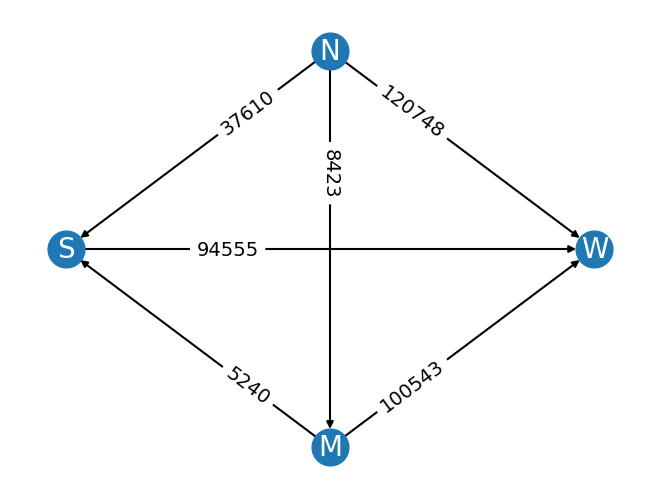



Do not ignore ambiguous marks

The number of ballots: 192289
        The number of empty ballots: 2773
        The number of ambiguous marks: 281
        The number of ballots with ambiguous marks: 173
        The number of ballots with multiple ranks for a candidate: 9037
        The number of ballots with overvote: 747
        The number of ballots with a skipped ranking: 6299
        The number of bullet votes: 51017
        The number of ballots with one ranking: 51615
        The number of ballots that were truncated: 1330      
        
After processing the ballots:

There are 4 candidates and 192289 rankings:  
        The number of empty rankings: 3235
        The number of rankings with ties: 0
        The number of linear orders: 10088
        The number of truncated linear orders: 178966
        
The number of rankings with skipped ranks: 5384
        
        
Margin graph using extended strict preference


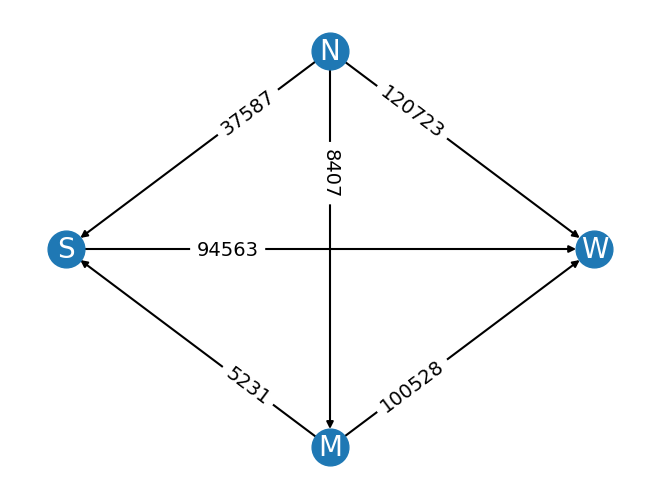

In [20]:
election_id = 69
cmap = {215: "N", 217:"S", 218: "M", 214: "W"}
max_rank = 4
rc_winner = 218

print("Alaska rules for truncating ballots\n")

print("\nIgnoring ambiguous marks\n")
prof1 = process_cvr_data(data, 
                         election_id, 
                         cmap, 
                         max_rank,
                         ignore_ambiguous_marks = True, 
                         truncation_type = "Alaska",
                         verbose=True)


prof1.use_extended_strict_preference()

print("Margin graph using extended strict preference")
prof1.display_margin_graph()

print()
# uncomment to see the rankings 
# print("The anonymous profile of rankings: ")
# prof1.display_rankings()

    
print("\nDo not ignore ambiguous marks\n")

prof2 = process_cvr_data(data, 
                         election_id, 
                         cmap, 
                         max_rank,
                         ignore_ambiguous_marks = False, 
                         truncation_type = "Alaska",
                         verbose=True)


prof2.use_extended_strict_preference()

print("Margin graph using extended strict preference")
prof2.display_margin_graph()

# uncomment to see the rankings 
#print("The anonymous profile of rankings: ")
#prof2.display_rankings()



+-------+-------+-------+-------+-------+-------+------+-------+------+
| 47404 | 23736 | 21260 | 27054 | 11280 | 15463 | 4648 | 34052 | 3654 |
+-------+-------+-------+-------+-------+-------+------+-------+------+
|   M   |   M   |   S   |   N   |   N   |   N   |  M   |   S   |  S   |
|   N   |  N S  |  N M  |   S   |  S M  |   M   |  S   |   N   |  M   |
|   S   |       |       |   M   |       |   S   |  N   |   M   |  N   |
+-------+-------+-------+-------+-------+-------+------+-------+------+


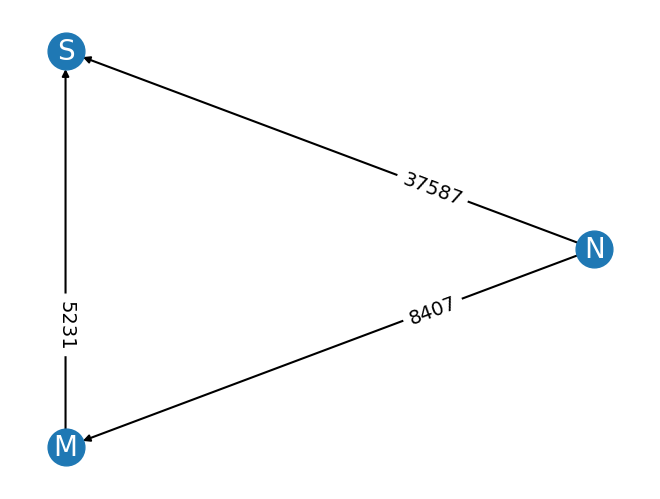

In [21]:
# anonymous rankings after removing candidate W (214)

_reduced_prof = prof2.remove_candidates([214])
_reduced_prof.remove_empty_rankings()

reduced_prof = _reduced_prof.add_unranked_candidates()

reduced_prof.display()
reduced_prof.display_margin_graph()

In [22]:
print(reduced_prof.description())

ProfileWithTies([{218: 1, 215: 2, 217: 3}, {218: 1, 215: 2, 217: 2}, {217: 1, 215: 2, 218: 2}, {215: 1, 217: 2, 218: 3}, {215: 1, 217: 2, 218: 2}, {215: 1, 218: 2, 217: 3}, {218: 1, 217: 2, 215: 3}, {217: 1, 215: 2, 218: 3}, {217: 1, 218: 2, 215: 3}], rcounts=[47404, 23736, 21260, 27054, 11280, 15463, 4648, 34052, 3654], cmap={215: 'N', 217: 'S', 218: 'M', 214: 'W'})


In [23]:
display_instant_runoff_results(prof2)

Instant Runoff round 1
	M plurality score: 74815
	S plurality score: 58544
	N plurality score: 52774
	W plurality score: 2921
	The candidate removed during this round: W
Instant Runoff round 2
	M plurality score: 75788
	S plurality score: 58966
	N plurality score: 53797
	The candidate removed during this round: N
Instant Runoff round 3
	M plurality score: 91251
	S plurality score: 86020
	The candidate removed during this round: S
The IRV winner is M


In [24]:
cw = prof2.condorcet_winner()

if cw is None: 
    print("There is no Condorcet winner.")
else: 
    print(f"The Condorcet winner is {cmap[cw]}.")

split_cycle.display(prof2)
stable_voting.display(prof2)
minimax.display(prof2)
beat_path.display(prof2)
copeland.display(prof2)

print()

cl = prof2.condorcet_loser()

if cl is None: 
    print("There is no Condorcet loser.")
else: 
    print(f"The Condorcet loser is {cmap[cl]}.")

The Condorcet winner is N.
Split Cycle winner is {N}
Stable Voting winner is {N}
Minimax winner is {N}
Beat Path winner is {N}
Copeland winner is {N}

The Condorcet loser is W.


In [25]:
instant_runoff_for_truncated_linear_orders.display(prof2)
irv_winner = instant_runoff_for_truncated_linear_orders(prof2)[0]
print(f"The margins of {cmap[irv_winner]} over each other candidate is: ")
for c in prof2.candidates: 
    if c != rc_winner:
        print(f"\tThe margin of {cmap[irv_winner]} over {cmap[c]} is {prof2.margin(rc_winner, c)}")

Instant Runoff (Truncated Linear Orders) winner is {M}
The margins of M over each other candidate is: 
	The margin of M over W is 100528
	The margin of M over N is -8407
	The margin of M over S is 5231


## Borda winners

In [26]:
print("Symmetric Borda: ", 
      ", ".join([prof1.cmap[c] for c in borda_for_profile_with_ties(prof1, borda_scores = symmetric_borda_scores)]))    
print("Domination Borda: ", 
      ", ".join([prof1.cmap[c] for c in borda_for_profile_with_ties(prof1, borda_scores = domination_borda_scores)]))    

print("Weak Domination Borda: ", 
      ", ".join([prof1.cmap[c] for c in borda_for_profile_with_ties(prof1, borda_scores = weak_domination_borda_scores)]))    

print("Non-Domination Borda: ", 
      ", ".join([prof1.cmap[c] for c in borda_for_profile_with_ties(prof1, borda_scores = non_domination_borda_scores)]))    


Symmetric Borda:  N
Domination Borda:  N
Weak Domination Borda:  N
Non-Domination Borda:  N


## Failure of Negative Involvement

In [27]:
init_prof, cmap = reduced_prof.truncate_overvotes()
init_prof.display()

instant_runoff_for_truncated_linear_orders.display(init_prof)


+-------+-------+-------+-------+-------+-------+------+-------+------+
| 47404 | 23736 | 21260 | 27054 | 11280 | 15463 | 4648 | 34052 | 3654 |
+-------+-------+-------+-------+-------+-------+------+-------+------+
|   M   |   M   |   S   |   N   |   N   |   N   |  M   |   S   |  S   |
|   N   |       |       |   S   |       |   M   |  S   |   N   |  M   |
|   S   |       |       |   M   |       |   S   |  N   |   M   |  N   |
+-------+-------+-------+-------+-------+-------+------+-------+------+
Instant Runoff (Truncated Linear Orders) winner is {M}


In [28]:
rankings, counts = init_prof.rankings_counts

print("After removing 5,170 voters with the ranking S N M, the winner is N")
new_counts = [c for c in counts]
new_counts[7] = new_counts[7] - 5170
new_prof = ProfileWithTies([r.rmap for r in rankings], rcounts=new_counts, cmap = reduced_prof.cmap)
new_prof.display()
instant_runoff_for_truncated_linear_orders.display(new_prof)

print("\nSo, N wins without 5,170 voters that rank M is last place.   With these voters in the election, their last place candidate M wins the election according to instant runoff voting. ")

After removing 5,170 voters with the ranking S N M, the winner is N
+-------+-------+-------+-------+-------+-------+------+-------+------+
| 47404 | 23736 | 21260 | 27054 | 11280 | 15463 | 4648 | 28882 | 3654 |
+-------+-------+-------+-------+-------+-------+------+-------+------+
|   M   |   M   |   S   |   N   |   N   |   N   |  M   |   S   |  S   |
|   N   |       |       |   S   |       |   M   |  S   |   N   |  M   |
|   S   |       |       |   M   |       |   S   |  N   |   M   |  N   |
+-------+-------+-------+-------+-------+-------+------+-------+------+
Instant Runoff (Truncated Linear Orders) winner is {N}

So, N wins without 5,170 voters that rank M is last place.   With these voters in the election, their last place candidate M wins the election according to instant runoff voting. 


In [ ]:
N = 215

num_negative_involvement_violations = 0

min_num_cands = 34052
max_num_cands = 0

for num_to_remove in tqdm(range(0, 34053)): 
    rankings, counts = init_prof.rankings_counts
    new_counts = [c for c in counts]
    new_counts[7] = new_counts[7] - num_to_remove
    new_prof = ProfileWithTies([r.rmap for r in rankings], rcounts=new_counts, cmap = reduced_prof.cmap)
    ws_without_voters = instant_runoff_for_truncated_linear_orders(new_prof)
    if [N] ==  ws_without_voters: 
        num_negative_involvement_violations += 1
        if num_to_remove < min_num_cands: 
            min_num_cands = num_to_remove
        if num_to_remove > max_num_cands: 
            max_num_cands = num_to_remove

print(f"{num_negative_involvement_violations} violations of Negative Involvement")

print(f"A minimum of {min_num_cands} or a maximum of {max_num_cands} voters demonstrate a violation of Negative Involvement")


for num_to_remove in tqdm(range(min_num_cands, max_num_cands+1)): 
    rankings, counts = init_prof.rankings_counts
    new_counts = [c for c in counts]
    new_counts[7] = new_counts[7] - num_to_remove
    new_prof = ProfileWithTies([r.rmap for r in rankings], rcounts=new_counts, cmap = reduced_prof.cmap)
    ws_without_voters = instant_runoff_for_truncated_linear_orders(new_prof)
    not_all_counterexamples = False
    if [N] !=  ws_without_voters: 
        not_all_counterexamples = True
        print(f"{num_to_remove} does not demonstrate a vioaltion of Negative Involvement.")
    
if not_all_counterexamples: 
    print(f"Not all groups of voters between {min_num_cands} to {max_num_cands} voters demonstrate a violation of Negative Involvement")
else:
    print(f"Removing any group of voters between {min_num_cands} to {max_num_cands} voters demonstrate a violation of Negative Involvement")


  0%|          | 0/34053 [00:00<?, ?it/s]

## Do not truncate ballots

Do not truncate ballots

Ignoring ambiguous marks
The number of ballots: 192289
        The number of empty ballots: 2776
        The number of ambiguous marks: 281
        The number of ballots with ambiguous marks: 173
        The number of ballots with multiple ranks for a candidate: 8899
        The number of ballots with overvote: 661
        The number of ballots with a skipped ranking: 6267
        The number of bullet votes: 51037
        The number of ballots with one ranking: 51612
        The number of ballots that were truncated: 0      
        
After processing the ballots:

There are 4 candidates and 192289 rankings:  
        The number of empty rankings: 2776
        The number of rankings with ties: 661
        The number of linear orders: 10093
        The number of truncated linear orders: 178759
        
The number of rankings with skipped ranks: 6267
        
        
Margin graph using extended strict preference


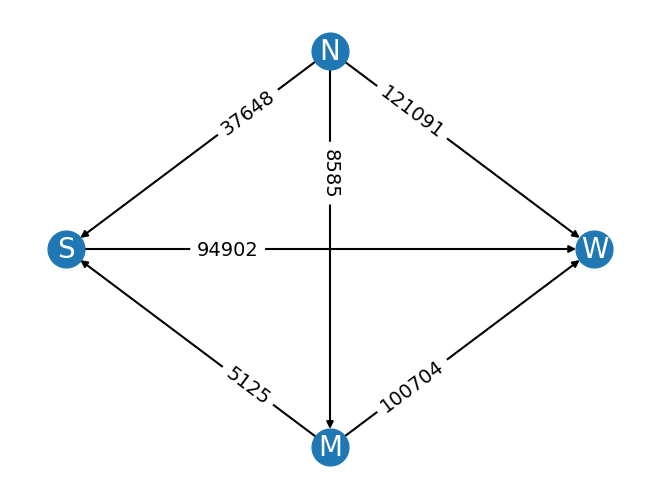


Do not ignore ambiguous marks
The number of ballots: 192289
        The number of empty ballots: 2773
        The number of ambiguous marks: 281
        The number of ballots with ambiguous marks: 173
        The number of ballots with multiple ranks for a candidate: 9037
        The number of ballots with overvote: 747
        The number of ballots with a skipped ranking: 6299
        The number of bullet votes: 51017
        The number of ballots with one ranking: 51615
        The number of ballots that were truncated: 0      
        
After processing the ballots:

There are 4 candidates and 192289 rankings:  
        The number of empty rankings: 2773
        The number of rankings with ties: 747
        The number of linear orders: 10088
        The number of truncated linear orders: 178681
        
The number of rankings with skipped ranks: 6299
        
        
Margin graph using extended strict preference


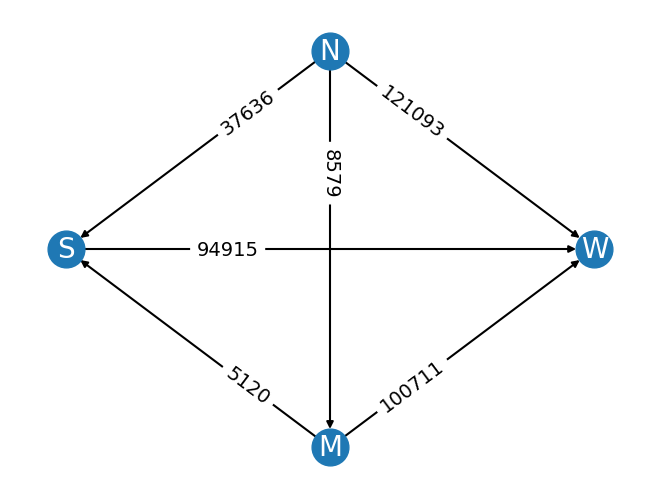

In [12]:

election_id = 69
cmap = {215: "N", 217:"S", 218: "M", 214: "W"}
max_rank = 4

print("Do not truncate ballots\n")

print("Ignoring ambiguous marks")
prof1 = process_cvr_data(data, 
                         election_id, 
                         cmap, 
                         max_rank,
                         ignore_ambiguous_marks = True, 
                         truncation_type = "simple",
                         verbose=True)

prof1.use_extended_strict_preference()

print("Margin graph using extended strict preference")
prof1.display_margin_graph()

## uncomment to display rankings
#prof1.display_rankings()
    
print("\nDo not ignore ambiguous marks")

prof2 = process_cvr_data(data, 
                         election_id, 
                         cmap, 
                         max_rank,
                         ignore_ambiguous_marks=False, 
                         truncation_type="simple",
                         verbose=True)

prof2.use_extended_strict_preference()

print("Margin graph using extended strict preference")
prof2.display_margin_graph()

## uncomment to display rankings
#prof2.display_rankings()



In [13]:
display_instant_runoff_results(prof2)

Instant Runoff round 1
	M plurality score: 74835
	S plurality score: 58580
	N plurality score: 52798
	W plurality score: 2952
	The candidate removed during this round: W
Instant Runoff round 2
	M plurality score: 75855
	S plurality score: 59048
	N plurality score: 53861
	The candidate removed during this round: N
Instant Runoff round 3
	M plurality score: 91434
	S plurality score: 86314
	The candidate removed during this round: S
The IRV winner is M


In [15]:
cw = prof2.condorcet_winner()

if cw is None: 
    print("There is no Condorcet winner.")
else: 
    print(f"The Condorcet winner is {cmap[cw]}.")

split_cycle.display(prof2)
stable_voting.display(prof2)
minimax.display(prof2)
beat_path.display(prof2)
copeland.display(prof2)

print()

cl = prof2.condorcet_loser()

if cl is None: 
    print("There is no Condorcet loser.")
else: 
    print(f"The Condorcet loser is {cmap[cl]}.")

The Condorcet winner is N.
Split Cycle winner is {N}
Stable Voting winner is {N}
Minimax winner is {N}
Beat Path winner is {N}
Copeland winner is {N}

The Condorcet loser is W.
